In [ ]:
import sys
import pandas as pd
import numpy as np
from rdkit import Chem
import umap.umap_ as umap
from rdkit.Chem import rdFingerprintGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time

## Generate a UMAP projection of prodrugs data over drugbank

In [ ]:
# function to remove salts
from rdkit.Chem import SaltRemover

def clean_smiles(smiles):

    if smiles is None:
        return None
    if isinstance(smiles, float):  
        return None
    
    smiles = str(smiles).strip()
    if smiles == "" or smiles.lower() == "nan":
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    fragments = Chem.GetMolFrags(mol, asMols=True)
    mol = max(fragments, default=None, key=lambda m: m.GetNumAtoms())
    if mol is None:
        return None

    remover = SaltRemover.SaltRemover()
    mol = remover.StripMol(mol, dontRemoveEverything=True)

    return Chem.MolToSmiles(mol)

In [ ]:
df = pd.read_csv("SI_Table20_COOHdrug_forZM.csv")
#df = df[df["DuplicateSalt"] != 1]


In [ ]:
# extract important columns
clean_df = df[['Hit_Flag', 'DrugStockName', 'Drug_SMILES_Clean']]
clean_df["Drug_SMILES_Clean"]

0      COC1=CC2=C(C=C1)[N](C(=C2CC(=O)OCC(O)=O)C)C(=O...
1                                 CC(C)CC(NC(C)=O)C(O)=O
2      CC1=CC=C(C=C1)C(=C\CN2CCCC2)/C3=CC=CC(=N3)\C=C...
3                            CC(=O)NC1=CC=C(CC(O)=O)C=C1
4                           OCCCCCCC(O)C(O)CCCCCCCC(O)=O
                             ...                        
165    CCCCC(=O)N(CC1=CC=C(C=C1)C2=CC=CC=C2C3=N[NH]N=...
166    CNC(CC(C)C)C(=O)NC1C(O)C2=CC(=C(OC3=C(OC4OC(CO...
167    CCC1=C(C(=O)C(N)=O)C2=C(C=CC=C2OCC(O)=O)[N]1CC...
168          CC(C(O)=O)C1=CC2=C(SC3=CC=CC=C3C(=O)C2)C=C1
169                                    OC(=O)CCCCCCCCC=C
Name: Drug_SMILES_Clean, Length: 170, dtype: object

In [ ]:
# drugbank csv file (initially extracted from DrugBank downloadable XML)
drugbank = pd.read_csv("/g/zimmermann/Databases/Drugbank/v5_1_13/FullDrugBank_XMLtoCSVv5_1_13.csv")
drugbank = drugbank[['drugbank_id', 'name', 'smiles', 'molweight']]
# search for small molecules
drugbank = drugbank[drugbank['molweight']<=1210] 

/tmp/ipykernel_24478/2537915546.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  drugbank = pd.read_csv("/g/zimmermann/Databases/Drugbank/v5_1_13/FullDrugBank_XMLtoCSVv5_1_13.csv")


In [9]:
len(drugbank)

12115

In [ ]:
# clean drugbank SMILES
drugbank.dropna(subset=['smiles'], inplace=True)
drugbank["smiles"] = [clean_smiles(i) for i in drugbank["smiles"]]
drugbank[drugbank["smiles"].notna()]
drugbank.dropna(subset=['smiles'], inplace=True)

/tmp/ipykernel_24478/1843885528.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  drugbank = pd.read_csv("/g/zimmermann/Databases/Drugbank/v5_1_13/FullDrugBank_XMLtoCSVv5_1_13.csv")
[09:38:17] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[09:38:17] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[09:38:17] SMILES Parse Error: check for mistakes around position 84:
[09:38:17] C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O
[09:38:17] ~~~~~~~~~~~~~~~~~~~~^
[09:38:17] SMILES Parse Error: extra open parentheses while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[09:38:17] SMILES Parse Error: check for mistakes around position 4

In [5]:
len(drugbank)

12104

In [ ]:
drugbank["ROMol"] = np.nan
drugbank["ROMol"] = [Chem.MolFromSmiles(i) for i in drugbank["smiles"]]
clean_df["mainSMILES"] = [clean_smiles(i) for i in clean_df["Drug_SMILES_Clean"]] 
clean_df["ROMol"] = np.nan
clean_df["ROMol"] = [Chem.MolFromSmiles(i) for i in clean_df["mainSMILES"]]

In [ ]:

# Assign Morgan Fingerprints to drugbank and the prodrugs df called clean_df
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
mol_fps_DB = [mfpgen.GetFingerprint(i) for i in drugbank["ROMol"]]
mol_fps_DF = [mfpgen.GetFingerprint(i) for i in clean_df["ROMol"]]
# Convert fingerprints to a NumPy array for UMAP
mol_fps_DB = np.array(mol_fps_DB, dtype=int)
mol_fps_DF = np.array(mol_fps_DF, dtype=int)

# generate the UMAP
# ---- CONFIG ----
RANDOM_SEED = 42
# ----------------

# Stack the two sets so they share the same UMAP space
X_union = np.vstack([mol_fps_DB, mol_fps_DF])

um = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    n_components=2,
    metric="jaccard",     
    random_state=RANDOM_SEED
)

embedding_union = um.fit_transform(X_union)


/tmp/ipykernel_2557/3728533486.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  drugbank = pd.read_csv("/g/zimmermann/Databases/Drugbank/v5_1_13/FullDrugBank_XMLtoCSVv5_1_13.csv")
[08:42:45] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[08:42:45] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[08:42:45] SMILES Parse Error: check for mistakes around position 84:
[08:42:45] C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O
[08:42:45] ~~~~~~~~~~~~~~~~~~~~^
[08:42:45] SMILES Parse Error: extra open parentheses while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[08:42:45] SMILES Parse Error: check for mistakes around position 40

/tmp/ipykernel_2557/873294088.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["Hit_Flag"] = clean_df["Hit_Flag"].fillna(0)
/tmp/ipykernel_2557/873294088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["Hit_Flag_label"] = clean_df["Hit_Flag"]


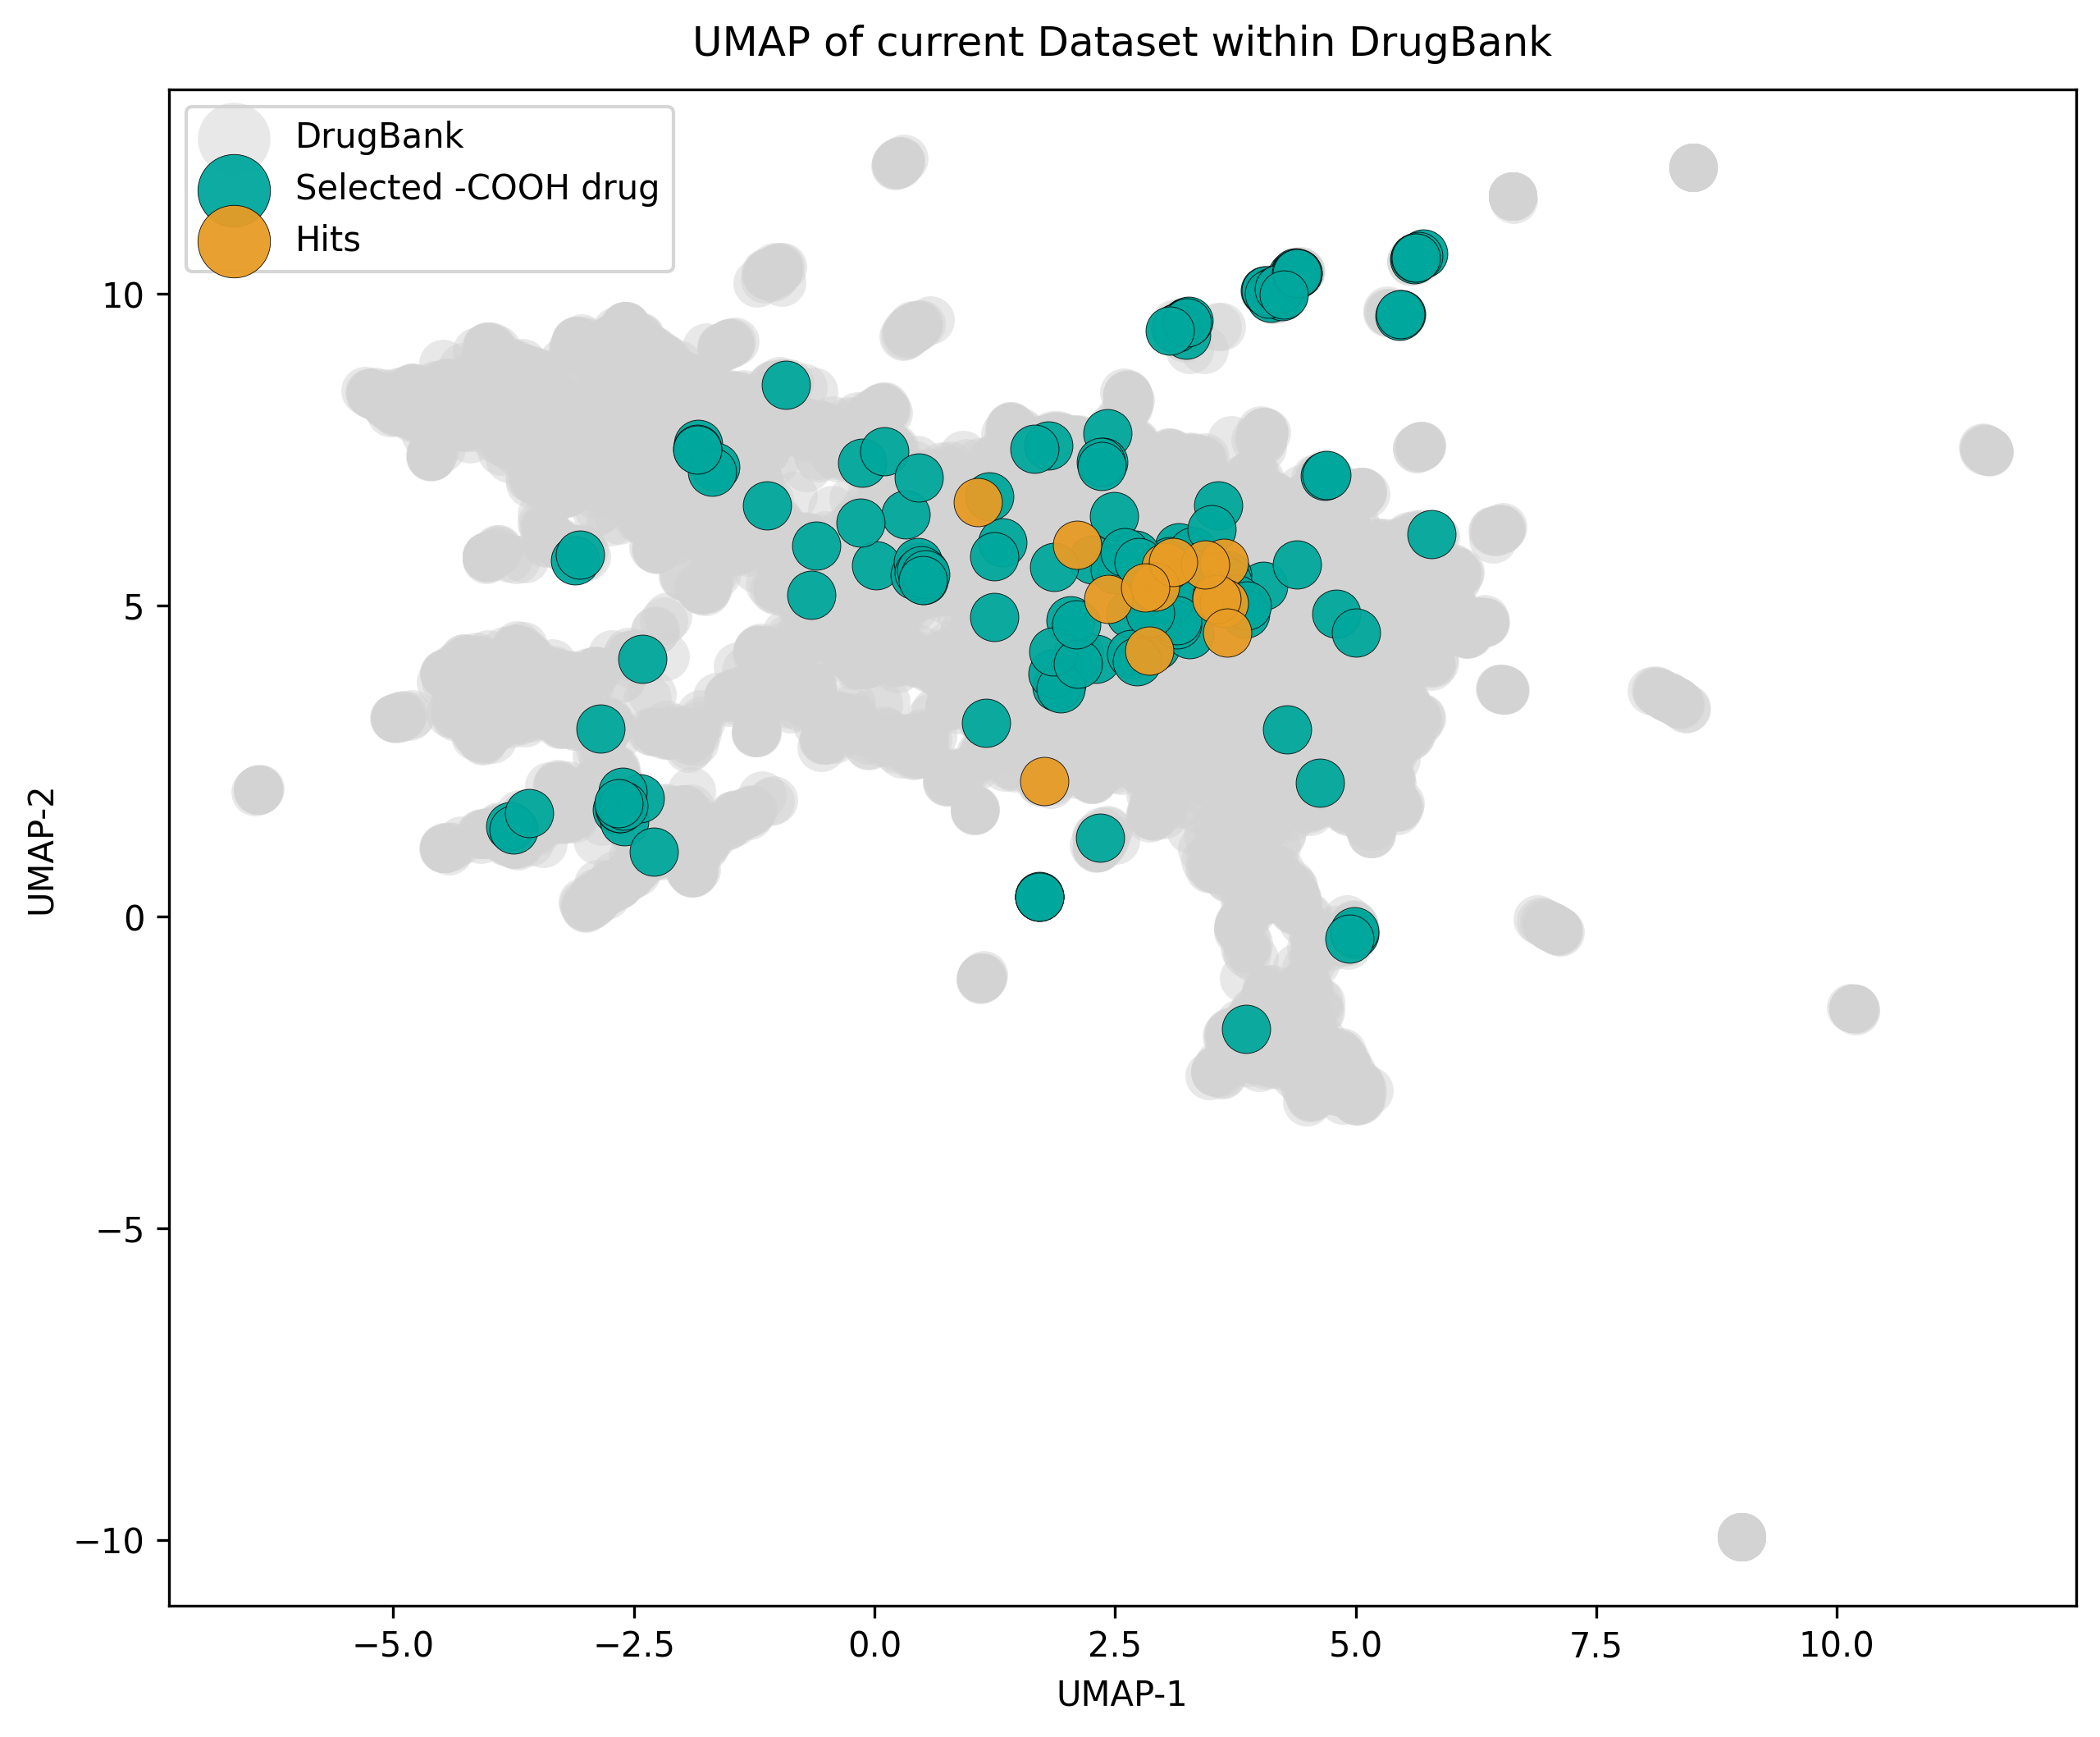

In [ ]:
# Separate embeddings
n_db = mol_fps_DB.shape[0]
emb_db   = embedding_union[:n_db]
emb_user = embedding_union[n_db:]
clean_df[clean_df["Hit_Flag"].notna()]
clean_df["Hit_Flag"] = clean_df["Hit_Flag"].fillna(0)
clean_df["Hit_Flag_label"] = clean_df["Hit_Flag"]
labels_user = clean_df["Hit_Flag_label"].values

# PLOT THE DATA
plt.figure(figsize=(10, 8), dpi=300)

# Background DrugBank
plt.scatter(
    emb_db[:,0], emb_db[:,1],
    s=200, marker='o', c='lightgray', alpha=0.5, linewidths=0, label="DrugBank"
)

# Foreground user data (label 0)
mask0 = labels_user == 0.0
plt.scatter(
    emb_user[mask0,0], emb_user[mask0,1],
    s=200, marker='o', c='#00A79C', alpha=0.95,
    edgecolors='black', linewidths=0.2,
    label="Selected -COOH drug"
)

# Foreground user data (label 1)
mask1 = labels_user == 1.0
plt.scatter(
    emb_user[mask1,0], emb_user[mask1,1],
    s=200, marker='o', c='#E79C25', alpha=0.95,
    edgecolors='black', linewidths=0.2,
    label="Hits"
)

plt.title("UMAP of current Dataset within DrugBank", fontsize=12, pad=10)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(frameon=True, markerscale=1.5) 



# Get UMAP embeddings
all_x = np.concatenate([emb_db[:, 0], emb_user[:, 0]])
all_y = np.concatenate([emb_db[:, 1], emb_user[:, 1]])


# Save the plot
output_filename = 'umap_compact_plot2_SI_map.pdf'
# Use bbox_inches='tight' to ensure the legend is not cut off
plt.savefig(output_filename, bbox_inches='tight')
plt.show()
# Finally, display the plot
plt.close()

## DrugBank Metadata collection

In [ ]:
## prepare your input dataframe
df = pd.read_csv("TK001D6_COOH_record_20250103_withMethylSMILES_cut_forMahnoor.csv")
#df = df.rename(columns={'smiles': 'SMILES'})
df["mainSMILES"] = [clean_smiles(i) for i in df["Drug_SMILES_Clean"]] 
df["ROMol"] = np.NaN
df["ROMol"] = [Chem.MolFromSmiles(i) for i in df["mainSMILES"]]
df["InChIKey"] = [Chem.rdinchi.MolToInchiKey(i) for i in df["ROMol"]]

In [ ]:
### Extract Pubchem IDs

def smiles_to_pubchem_cid(smiles, max_retries=3):

    if pd.isna(smiles) or smiles == '':
        return None
    
    # Query PubChem API
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/cids/JSON"
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                cids = data.get('IdentifierList', {}).get('CID', [])
                if cids:
                    return cids[0]  # Return first CID
            time.sleep(0.5)  # Rate limiting
        except Exception as e:
            print(f"Error for SMILES {smiles[:50]}: {e}")
            time.sleep(1)
    
    return None


print("Extracting PubChem CIDs for df data...")
df['PubChemID'] = df['mainSMILES'].apply(
    lambda x: smiles_to_pubchem_cid(x) if pd.notna(x) else None
)


print(f"Internal: {df['PubChemID'].notna().sum()}/{len(df)} CIDs found")

In [ ]:
## read DrugBank file

drugbank = pd.read_csv("/g/zimmermann/Databases/Drugbank/v5_1_12/FullDrugBank_XMLtoCSV.csv")
drugbank = drugbank[drugbank['molweight']<=1210]
drugbank = drugbank.rename(columns={'smiles': 'SMILES', 'inchikey': 'InChIKey'})
drugbank = drugbank[['drugbank_id', 'name', 'aliases', 'UniProtID',
       'PubChemID', 'ChEMBLID', 'description', 'groups', 'cas_no', 'inchi',
       'InChIKey', 'SMILES', 'iupac', 'indication', 'pharmacodynamics',
       'action_mechanism', 'toxicity', 'metabolism', 'absorption',
       'elimination', 'atc_codes', 'categories', 'bioavail']]

/tmp/ipykernel_88780/2342985159.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  drugbank = pd.read_csv("/g/zimmermann/Databases/Drugbank/v5_1_12/FullDrugBank_XMLtoCSV.csv")


In [ ]:
### based on cas no.

In [ ]:
df = df.rename(columns={"CAS Number": "cas_no"})

In [ ]:
### remove repeated entries with CAS no.
drugbank_dup = drugbank.drop_duplicates(subset='cas_no', keep='first')

In [140]:
merged = pd.merge(
    df,
    drugbank_dup,
    on='cas_no',
    how='left',
    suffixes=('', '_drugbank')
)
merged[['Name', 'drugbank_id']]
len(merged[merged['drugbank_id'].notna()])

96

In [145]:
missing_mask = merged['drugbank_id'].isna()
missing_rows = merged[missing_mask]

print(f"{len(missing_rows)} rows have missing drugbank_id after CAS merge")

93 rows have missing drugbank_id after CAS merge


In [ ]:
## merge by PubChemIds
if 'PubChemID' in df.columns and 'PubChemID' in drugbank.columns:
    pubchem_merge = pd.merge(
        missing_rows.drop(columns=['drugbank_id'], errors='ignore'),
        drugbank[['PubChemID', 'drugbank_id']].drop_duplicates(subset='PubChemID'),
        on='PubChemID',
        how='left'
    )
    
    #  fill in drugbank_id where found
    merged.loc[missing_mask, 'drugbank_id'] = pubchem_merge['drugbank_id']
else:
    print("One of the DataFrames does not have a 'PubChemID' column!")

# check results
print(f"After PubChem matching, {merged['drugbank_id'].notna().sum()} rows have DrugBank IDs.")

After PubChem matching, 107 rows have DrugBank IDs.


In [ ]:
missing_mask = merged['drugbank_id'].isna()
missing_rows = merged[missing_mask]
print(f"{len(missing_rows)} rows have missing drugbank_id after PubChem merge")

82 rows have missing drugbank_id after CAS merge


In [ ]:
## add based on InChIKey
if 'InChIKey' in df.columns and 'InChIKey' in drugbank.columns:
    pubchem_merge = pd.merge(
        missing_rows.drop(columns=['drugbank_id'], errors='ignore'),
        drugbank[['InChIKey', 'drugbank_id']].drop_duplicates(subset='InChIKey'),
        on='InChIKey',
        how='left'
    )
    
    # fill in drugbank_id where found
    merged.loc[missing_mask, 'drugbank_id'] = pubchem_merge['drugbank_id']
else:
    print("One of the DataFrames does not have a 'InChIKey' column!")

# check results
print(f"After InChIKey matching, {merged['drugbank_id'].notna().sum()} rows have DrugBank IDs.")

After InChIKey matching, 110 rows have DrugBank IDs.


In [ ]:
missing_mask = merged['drugbank_id'].isna()
missing_rows = merged[missing_mask]
print(f"{len(missing_rows)} rows have missing drugbank_id after InChIKey merge")

79 rows have missing drugbank_id after CAS merge


In [ ]:
merged.to_csv("TK001D6_COOH_record_20250103_withMethylSMILES_DrugBank.csv")